# Fashion-MNIST 데이터 CNN을 통한 이미지 분류

-------------------------------------------------------------------------------------

본 과제에서는 Fashion-MNIST 데이터를 활용하여 CNN 모델을 구축하여 데이터를 학습시켜 모델을 평가하는 과정을 통하여 정확도 확인 및 잘못 분류된 이미지에 대한 분석을 진행한다.

- 1. Fashion-MNIST 데이터셋 로드 및 훈련 데이터, 테스트 데이터로 분할

- 2. 이미지 데이터의 형태 및 클레스 레이블을 시각적 탐색 및 분석 진행

- 3. CNN 모델 구축 (1개의 컨볼루션 레이어, 풀링 레이어 포함)

- 4. 모델 컴파일 및 손실 함수와 최적화 알고리즘 선택 및 구현

- 5. 훈련 데이터를 모델에 학습시키고 학습 과정의 손실과 정확도 모니터링을 통한 확인

- 6. 학습을 완료한 모델에 테스트 데이터를 통해 모델을 평가 후 최종 정확도 보고

- 7. 잘못된 분류 이미지 분석 및 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지 시각화 자료를 통해 확인 진행

총 7단계의 과정을 통해 진행된다.

-------------------------------------------------------------------------------------

# 작업 환경

-------------------------------------------------------------------------------------

- Python Version : 3.10.13


-------------------------------------------------------------------------------------


# 필요한 라이브러리 설치 및 환경 준비

In [1]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

%pip install torchvision # torchvision 라이브러리 설치
%pip install torchinfo # torchinfo 라이브러리 설치
%pip install pytorchcv # pytorchcv 라이브러리 설치
%pip install torchsummary # 신경망 모델의 요약 정보를 보여주는 라이브러리 설치

# 데이터셋 읽어오는 모듈
import numpy as np #numpy (배열 처리)

# CNN 구성
import torch #pytorch import 진행
import torch.nn as nn #신경망을 위한 nn 정의
import torchvision #torchvision
import pytorchcv #py
import torch.optim as optim #최적화 구현 패키지
import torch.nn.functional as F
import pylab
import matplotlib.pyplot as plt #시각화를 위한 pyplot
from torchinfo import summary #모델의 구조를 확인 위한 torchinfo

from pytorchcv import load_Fasion_mnist, train, plot_results, plot_convolution, display_dataset, validate

--2024-04-18 13:14:42--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py.1’

pytorchcv.py.1      100%[===================>]   6.39K  --.-KB/s    in 0.001s  

2024-04-18 13:14:42 (8.73 MB/s) - ‘pytorchcv.py.1’ saved [6540/6540]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# 1. Fashion-MNIST 데이터셋 로드 및 훈련 데이터, 테스트 데이터로 분할

In [2]:
# 미리 정의해둔 load_Fasion_minst를 batch_size를 64로 지정하여 train_data와 test_data로 분할 진행
train_data = load_Fasion_mnist(batch_size=64)
test_data = load_Fasion_mnist(batch_size=64)

# data 형식 확인 (FashionMNIST로 정상적인 데이터를 읽어온 사실을 확인 가능함)
print(type(data_train))
print(type(data_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
<class 'torchvision.datasets.mnist.FashionMNIST'>


# 2. 이미지 데이터의 형태 및 클레스 레이블을 시각적 탐색 및 분석 진행 (training data에 대한 추가)

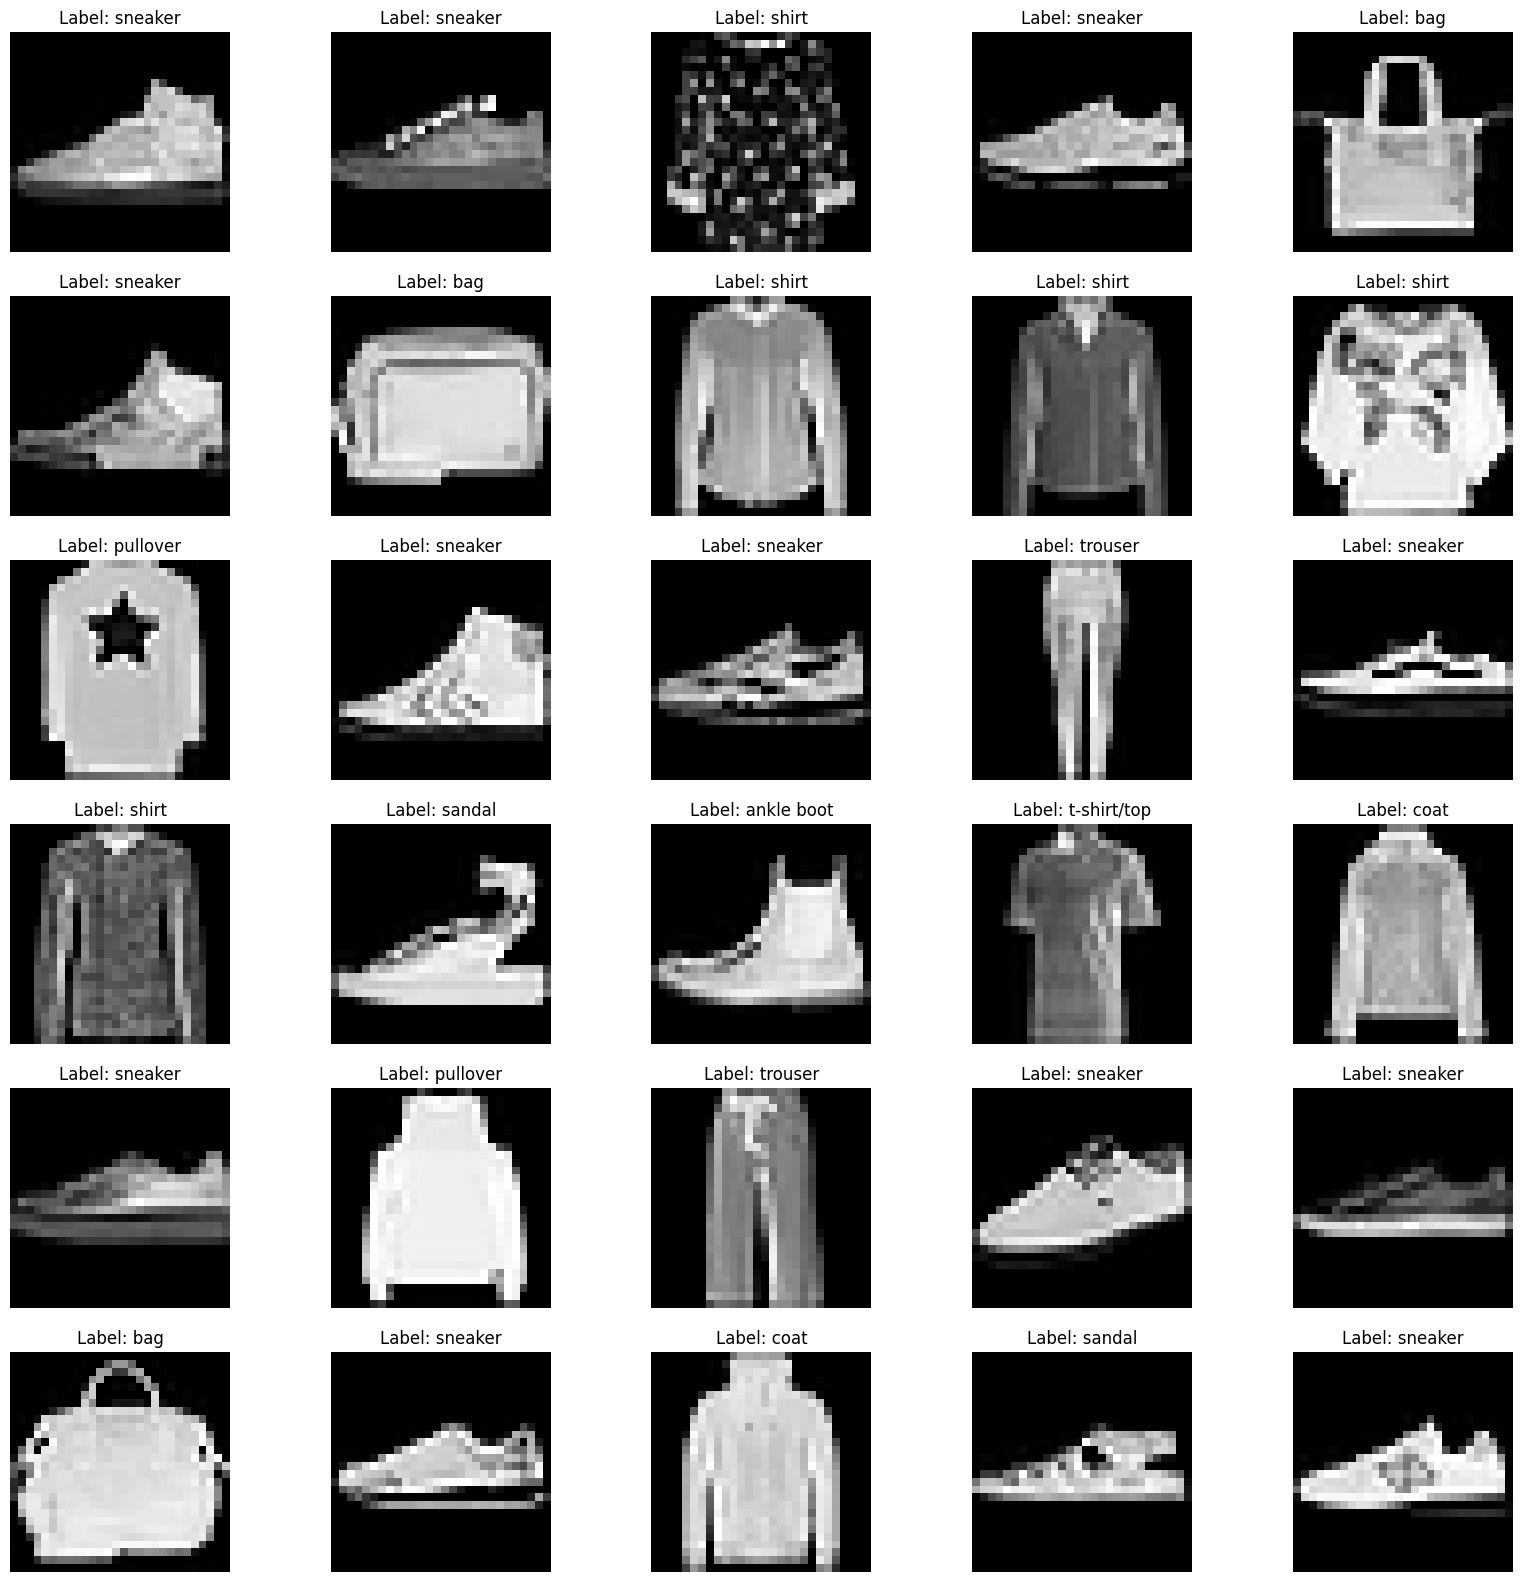

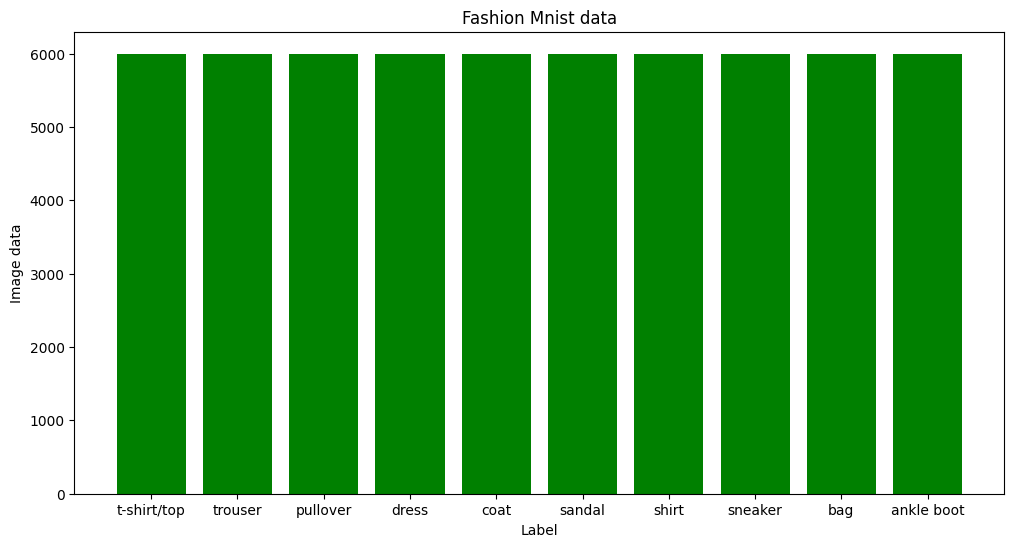

{9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000}


In [3]:
# 이미지 데이터에 저장되어 있는 종류를 출력하기 전에 레이블을 공식 데이터에 따라 정의
labels_map = { 0: "t-shirt/top", 1: "trouser", 2: "pullover", 3: "dress", 4: "coat", 5: "sandal", 6: "shirt", 7: "sneaker", 8: "bag", 9: "ankle boot"}

# 1). cmap을 통해 이미지 데이터 중 랜덤으로 뽑아 종류에 대한 확인
# 하단의 cmap을 통해서 확인하면 데이터는 gray 이미지로 구성되어 있음을 확인 가능하다. 

figure = plt.figure(figsize=(20, 20)) #사이즈를 20, 20으로 지정
cols, rows = 5, 6 #5행 6열 구성으로 총 30개의 샘플 데이터가 출력될 것임.

for i in range(1, cols * rows + 1): # 위에서 지정한 배열에 맞게 30개의 샘플 데이터를 출력함
    sample_idx = torch.randint(len(data_train), size=(1,)).item() #torch의 randint를 이용해 랜덤한 인덱스 하나를 선택함
    img, label = data_train[sample_idx] #data_train에 sample_idx에 해당하는 이미지와 레이블을 가져옴
    
    figure.add_subplot(rows, cols, i) # 순서대로 이미지와 레이블을 추가함
    plt.title(f"Label: {labels_map[label]}") # 레이블 명을 이미지 위에 추가 (위에서 정의한 레이블 명을 해당하는 것을 찾아서 추가)
    plt.axis("off") # 세부적인 눈금이나 필요없는 것들은 지워버림
    plt.imshow(img.squeeze(), cmap="gray") # 이미지를 보여주며, gray 이미지로 표시함.

plt.show() # 이미지 보기

# 2). data_train을 lable의 종류에 따라 데이터양을 확인해보기
# data_train 내부에 image와 label이 함께 있기 때문에 반복문을 통해 image와 lable을 검사하며 0부터 시작하여 9까지의 레이블에 해당하는 이미지를 찾을 경우 count를 진행하여 하단의 label_counts에 저장을 진행함
# 1. label_count 진행
# 2. label_count를 sort를 진행하여 0 ~ 9까지 순서대로 정렬
# 3. labels에 기존에 정의해둔 레이블 명칭을 더하여 리스트화 시킴
# 4. counts에는 label_count에 저장해둔 이미지 데이터의 수를 리스트화 시킴
# 5. plt를 통해 막대 그래프로 데이터의 갯수를 시각화하여 출력함

label_counts = {}  # 0 ~ 9
# data_train에서 이미지와 레이블을 순회하며 이미지 데이터의 양을 count하여 label_counts에 저장함
for image, label in data_train: #image와 label를 각 data_train의 모든 데이터를 돌며 뽑아냄
    if label in label_counts: # label이 label_count에 저장된 값이 해당될 경우
        label_counts[label] += 1  # 이미지 갯수 +1
    else:  # 이미지 데이터에 해당하는 레이블이 label_counts에 없으면
        label_counts[label] = 1  # 해당하는 이미지 레이블 값의 키를 새로 만들어서 추가함

# 레이블별 이미지 데이터 수를 key로 두고 정렬을 진행하여 딕셔너리로 만들어 sorted_label_counts에 저장함
sorted_label_counts = dict(sorted(label_counts.items()))

# 정렬된 상태의 딕셔너리의 키값과 value를 뽑아서 시각화를 위해 따로 빼서 저장을 진행함
labels = [labels_map[label] for label in sorted_label_counts.keys()]  # 레이블의 이름은 위에서 정의해둔 labels_map에서 해당하는 값을 가져와 바꿔서 저장함
counts = list(sorted_label_counts.values())  # 이미지 데이터 수를 저장함

# 막대 그래프 그리기
plt.figure(figsize=(12, 6))  # 그래프 크기 지정
plt.bar(labels, counts, color='green')  # 막대 그래프 (녹색)
plt.xlabel('Label')  # x축 이름
plt.ylabel('Image data')  # y축 이름
plt.title('Fashion Mnist data')  # 그래프 제목
plt.show() # 그래프 출력

# 레이블에 해당하는 이미지 데이터의 갯수 출력
print(label_counts)


# 3. CNN 모델 구축 (1개의 컨볼루션 레이어, 풀링 레이어 포함)

In [4]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명
import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
%pip install torchsummary # 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트

class CNN_model(nn.Module): # nn.Module을 상속받는 CNN_model라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self): # 클래스의 생성자로, CNN_model 객체가 생성될 때 초기화 과정을 정의
        super(CNN_model, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당 (커널사이즈 5x5)
        self.max_pool = nn.MaxPool2d(kernel_size=2) # 풀링 레이어 추가
        self.flatten = nn.Flatten() # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        self.fc = nn.Linear(5184,10) # 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 로그 소프트맥스 함수를 통해 처리하는데 이 함수는 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용

        return x 

# 모델 인스턴스 생성
net = CNN_model() # OneConv 클래스의 인스턴스를 생성

# 모델에 대한 요약 데이터 출력
summary(net,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


# 4. 모델 컴파일 및 손실 함수와 최적화 알고리즘 선택 및 구현

In [5]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: # # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)

            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환


# 5. 훈련 데이터를 모델에 학습시키고 학습 과정의 손실과 정확도 모니터링을 통한 확인

Epoch 1/10: Train Loss: 0.0081, Train Acc: 81.98%, Test Loss: 0.0069, Test Acc: 84.41%
Epoch 2/10: Train Loss: 0.0059, Train Acc: 86.77%, Test Loss: 0.0059, Test Acc: 86.51%
Epoch 3/10: Train Loss: 0.0052, Train Acc: 88.22%, Test Loss: 0.0056, Test Acc: 87.59%
Epoch 4/10: Train Loss: 0.0048, Train Acc: 89.15%, Test Loss: 0.0054, Test Acc: 88.04%
Epoch 5/10: Train Loss: 0.0044, Train Acc: 89.88%, Test Loss: 0.0053, Test Acc: 88.35%
Epoch 6/10: Train Loss: 0.0042, Train Acc: 90.50%, Test Loss: 0.0052, Test Acc: 88.55%
Epoch 7/10: Train Loss: 0.0039, Train Acc: 91.08%, Test Loss: 0.0052, Test Acc: 88.73%
Epoch 8/10: Train Loss: 0.0037, Train Acc: 91.51%, Test Loss: 0.0051, Test Acc: 88.80%
Epoch 9/10: Train Loss: 0.0035, Train Acc: 91.95%, Test Loss: 0.0052, Test Acc: 88.77%
Epoch 10/10: Train Loss: 0.0034, Train Acc: 92.33%, Test Loss: 0.0052, Test Acc: 88.93%


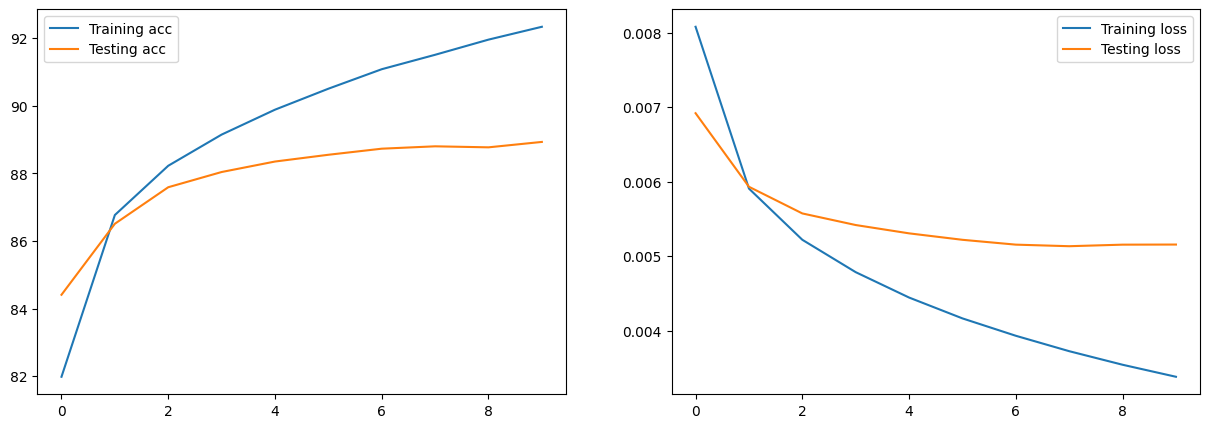

In [6]:
# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train(net, train_loader, test_loader, epochs=10)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌


# plot을 통해 출력된 결과를 확인하면 4회 학습까지 유의미한 결과를 보이다가 5회 학습 이후로 학습 모델에 정확도가 88 ~ 89%에서 머물렀으며 테스트 정확도는 9회 학습을 기점으로 떨어지기 시작하였다.
# 10회 이상의 학습은 무의미하다고 판단되며 오히러 오버피팅의 결과를 초래할 가능성이 있어 보인다.

# 6. 학습을 완료한 모델에 테스트 데이터를 통해 모델을 평가 후 최종 정확도 보고

In [7]:
# Pytorchcv.py에 정의된 validate 함수를 통해 테스트 데이터를 통하여 검증을 진행하고 정확도를 출력 진행함
loss_val, acc_val = validate(net, test_loader) # 학습을 완료한 net 모델에 test_loader 데이터를 통해 예측에 대한 검증을 진행하고 오류 수치와 정확도를 받음
print("최종 모델 성능 결과")
print("="*30)
print(f"Validation Loss: {loss_val:.4f}, Validation Accuracy: {acc_val:.4f}")
print("="*30)

# 최종 성능은 89 ~ 90% 사이로 확인 가능함

최종 모델 성능 결과
Validation Loss: 0.0052, Validation Accuracy: 0.8893


# 7. 잘못된 분류 이미지 분석 및 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지 시각화 자료를 통해 확인 진행

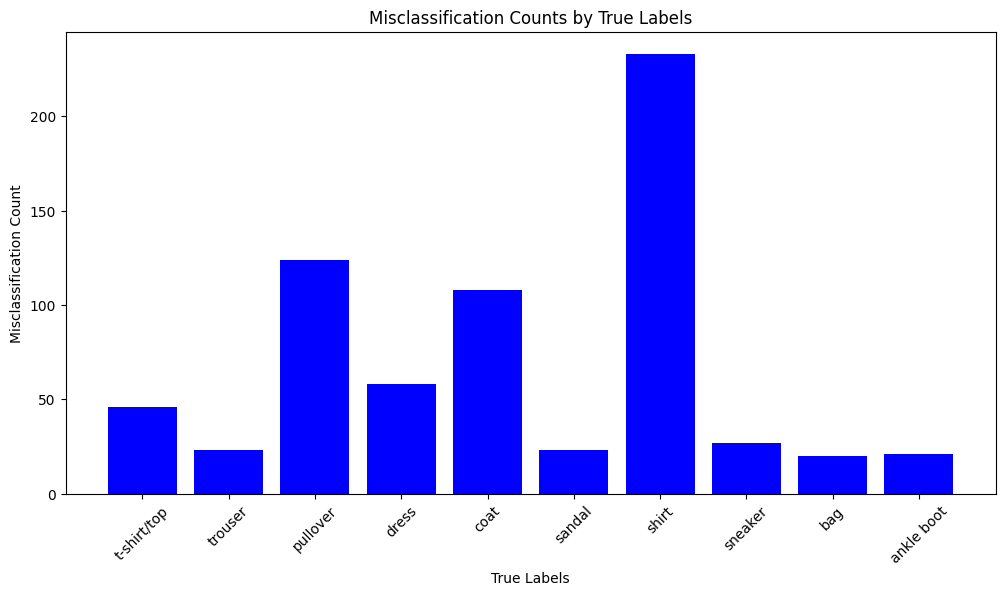

In [8]:
def analyze_misclassified(net, dataloader, labels_map):
    default_device = "cpu"
    net.eval()
    misclassified_counts = {label: 0 for label in labels_map.values()}
    
    with torch.no_grad():
        for features, labels in dataloader:
            features = features.to(default_device)
            labels = labels.to(default_device)
            
            outputs = net(features)
            _, predicted = torch.max(outputs, 1)
            
            misclassified_idx = (predicted != labels).nonzero().squeeze()
            
            for idx in misclassified_idx:
                true_label = labels[idx].item()
                misclassified_counts[labels_map[true_label]] += 1
    
    # Plotting the misclassification counts
    labels = list(misclassified_counts.keys())
    counts = list(misclassified_counts.values())
    
    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color='blue')
    plt.xlabel('True Labels')
    plt.ylabel('Misclassification Count')
    plt.title('Misclassification Counts by True Labels')
    plt.xticks(rotation=45)
    plt.show()


n = 60000  # Total number of test samples
batch_size = 1000  # Batch size of the test loader

# Create a mini test loader by taking a subset of test_loader
mini_test_loader = torch.utils.data.DataLoader(
    test_loader.dataset,
    batch_size=batch_size,
    sampler=torch.utils.data.SequentialSampler(range(int(n/10))),
    shuffle=False
)

# analyze_misclassified 함수 정의 및 호출
analyze_misclassified(net, mini_test_loader, labels_map)


상단의 분류 오류 발생에 대한 plot 결과를 확인하면, shirt, pullover, coat, dress, t-shirt를 순서로 가장 많은 모델에 의한 분류 오류가 발생한 사실을 확인 가능하다.